In [ ]:
"""
aggregate the sentiment scores of comments to articles
and then to topics

will weight comment sentiments by comment scores

add +1 to zero scores, so comment with no votes gets weight of 1 for the person that posted it
currently, any post automatically gets +1 when user posts, but older years did not and have zero 

comment with negative score will get weight of  zero - 
    assuming negative score means fellow community members disagree and will not include in sentiment
    about article or topic

"""

In [75]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt

In [33]:
with open('comments_sentiment.pickle', 'rb') as read_file:
    comments = pickle.load(read_file)
    
comments.shape

(290871, 18)

In [34]:
min(comments.score)

-187.0

In [39]:
comments.score.value_counts()

 1.0      225080
 2.0       17855
 3.0        9062
 0.0        6628
 4.0        4032
           ...  
 325.0         1
 221.0         1
-53.0          1
 672.0         1
 226.0         1
Name: score, Length: 391, dtype: int64

In [40]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290871 entries, 0 to 290870
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   author              290871 non-null  object 
 1   author_created_utc  46645 non-null   float64
 2   body                290871 non-null  object 
 3   created_utc         290869 non-null  object 
 4   id                  290869 non-null  object 
 5   link_id             290869 non-null  object 
 6   parent_id           290869 non-null  object 
 7   parent_id           290869 non-null  object 
 8   permalink           272782 non-null  object 
 9   retrieved_on        289606 non-null  float64
 10  score               290867 non-null  float64
 11  created             290867 non-null  float64
 12  subreddit           290867 non-null  object 
 13  updated_utc         25343 non-null   float64
 14  neg                 290871 non-null  float64
 15  neu                 290871 non-nul

In [41]:
# couple missing scores
comments[comments.score.isin([np.nan])]

# these are also missing the link_id to connect to the article, so will remove
# looks like something in the Pushshift API records miss-aligned the data with fields

,author,author_created_utc,body,created_utc,id,link_id,parent_id,parent_id,permalink,retrieved_on,score,created,subreddit,updated_utc,neg,neu,pos,compound
9127,HULKx,1.393546e+09,They aren't allowed to direct hire you for a s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000,0.000,0.0000
9128,Everything else you described is the same as m...,0.000000e+00,ch8sfvg,1.0,1433637576,3,technews,technews,NaN,1.399171e+09,NaN,NaN,NaN,NaN,0.0,1.000,0.000,0.0000
54718,delicioussandwiches,1.335201e+09,Reddit is a fantastic source of market trends ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.667,0.333,0.7579
54719,The valuation is based purely on what it could...,0.000000e+00,0,t3_3fbun9,1440220535,1,technews,technews,NaN,1.438463e+09,NaN,NaN,NaN,NaN,0.0,1.000,0.000,0.0000


In [42]:
f1_comments = comments[~comments.score.isin([np.nan])]
f1_comments.shape

(290867, 18)

In [43]:
len(comments[comments['score'] == 0])

6628

In [44]:
comments['comment_weight'] = np.where(comments['score'] ==0, comments['score']+1, comments['score'])


In [45]:
len(comments[comments['score']<0])

6074

In [46]:
# comments the subreddit community agreed with

comm_comments = comments[comments['score'] >=0]
comm_comments.shape

(284793, 19)

In [47]:
# add sentiment * comment_weight for each comment
# then will do weighted average of sentiment scores

comm_comments['sentXwgt'] = comm_comments['compound'] * comm_comments['comment_weight']

comm_comments.head()

<ipython-input-47-69436d3b2f5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_comments['sentXwgt'] = comm_comments['compound'] * comm_comments['comment_weight']


,author,author_created_utc,body,created_utc,id,link_id,parent_id,parent_id,permalink,retrieved_on,score,created,subreddit,updated_utc,neg,neu,pos,compound,comment_weight,sentXwgt
0,wsxedcrf,1.390431e+09,"Sure, something like What's the weather? Set t...",1514775934.0,ds0v85z,t3_7m68fe,t3_7m68fe,t3_7m68fe,/r/technews/comments/7m68fe/46_of_americans_us...,1.517442e+09,1.0,1.514794e+09,technews,NaN,0.060,0.749,0.191,0.5411,1.0,0.5411
1,SoundDr,1.363845e+09,They are just as bad as patent trolls. I love ...,1514765852.0,ds0nxpm,t3_7n92ka,t1_ds02bc5,t1_ds02bc5,/r/technews/comments/7n92ka/steve_jobs_is_an_i...,1.517436e+09,4.0,1.514784e+09,technews,NaN,0.114,0.749,0.137,0.1779,4.0,0.7116
2,negativerad,1.265179e+09,Steve Jobs,1514764847.0,ds0n4dz,t3_7n92ka,t1_ds0klv2,t1_ds0klv2,/r/technews/comments/7n92ka/steve_jobs_is_an_i...,1.517433e+09,1.0,1.514783e+09,technews,NaN,0.000,1.000,0.000,0.0000,1.0,0.0000
3,snapmehummingbirdeb,1.435642e+09,The real question is who would want to wear by...,1514761787.0,ds0klv2,t3_7n92ka,t3_7n92ka,t3_7n92ka,/r/technews/comments/7n92ka/steve_jobs_is_an_i...,1.514762e+09,1.0,1.514780e+09,technews,1.514762e+09,0.000,0.894,0.106,0.0772,1.0,0.0772
4,autotldr,1.327942e+09,"This is the best tl;dr I could make, [original...",1514755490.0,ds0fby8,t3_7l4gfm,t3_7l4gfm,t3_7l4gfm,/r/technews/comments/7l4gfm/want_to_guarantee_...,1.514755e+09,1.0,1.514773e+09,technews,1.514755e+09,0.013,0.836,0.152,0.9601,1.0,0.9601


In [50]:
# aggregate based on link_id

agg_linkID = comm_comments.groupby(['link_id']).agg({'sentXwgt': np.sum, 'comment_weight': np.sum}).reset_index()
agg_linkID.head()

,link_id,sentXwgt,comment_weight
0,t3_10sqb1,0.5685,18.0
1,t3_10tetw,0.0516,3.0
2,t3_125zd4,0.0000,1.0
3,t3_127s35,0.2520,1.0
4,t3_13nytw,0.5255,1.0


In [52]:
comm_comments[comm_comments['link_id']=='t3_10tetw']

,author,author_created_utc,body,created_utc,id,link_id,parent_id,parent_id,permalink,retrieved_on,score,created,subreddit,updated_utc,neg,neu,pos,compound,comment_weight,sentXwgt
290848,Zilveari,1.348154e+09,Wow... I'm screwing every post up today... thi...,1349193880,c6gi61z,t3_10tetw,t3_10tetw,t3_10tetw,NaN,1.430044e+09,1.0,1.349212e+09,technews,NaN,0.154,0.742,0.104,0.0516,1.0,0.0516
290849,inspired2apathy,1.222228e+09,link?,1349193643,c6gi3nd,t3_10tetw,t3_10tetw,t3_10tetw,NaN,1.430044e+09,2.0,1.349212e+09,technews,NaN,0.000,1.000,0.000,0.0000,2.0,0.0000


In [54]:
agg_linkID['wgt_avg_sent'] = agg_linkID['sentXwgt'] / agg_linkID['comment_weight']

agg_linkID.head()

,link_id,sentXwgt,comment_weight,wgt_avg_sent
0,t3_10sqb1,0.5685,18.0,0.031583
1,t3_10tetw,0.0516,3.0,0.017200
2,t3_125zd4,0.0000,1.0,0.000000
3,t3_127s35,0.2520,1.0,0.252000
4,t3_13nytw,0.5255,1.0,0.525500


In [55]:
agg_linkID['post_id'] = agg_linkID['link_id'].str[3:]

agg_linkID.head()

,link_id,sentXwgt,comment_weight,wgt_avg_sent,post_id
0,t3_10sqb1,0.5685,18.0,0.031583,10sqb1
1,t3_10tetw,0.0516,3.0,0.017200,10tetw
2,t3_125zd4,0.0000,1.0,0.000000,125zd4
3,t3_127s35,0.2520,1.0,0.252000,127s35
4,t3_13nytw,0.5255,1.0,0.525500,13nytw


In [56]:
# posts with comments
agg_linkID.shape

(10110, 5)

In [ ]:
##########################

In [57]:
#match to articles and article topic assignment

with open('cv_nmf_topics_posts2.pickle', 'rb') as read_file:
    posts = pickle.load(read_file)
    
posts.head()


,index,id,created_utc,date_time,author,author_fullname,title,url,domain,num_comments,...,C_10,C_11,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19
0,0,29j6ov,1404184792,2014-07-01 03:19:52,Password_is_123456,t2_6crtu,New leaks show off the iPhone 6's curved edged...,http://www.cnet.com/news/new-leaks-show-off-up...,cnet.com,0,...,0.00000,0.15604,0.00000,0.00000,0.00526,0.00000,0.00000,0.00000,0.00000,0.00000
1,1,29j6op,1404184791,2014-07-01 03:19:51,Password_is_123456,t2_6crtu,Millions of dynamic DNS users suffer after Mic...,http://arstechnica.com/security/2014/06/millio...,arstechnica.com,6,...,0.00009,0.00170,0.00000,0.18426,0.00000,0.00000,0.01007,0.00000,0.00000,0.00000
2,2,29j2c1,1404181722,2014-07-01 02:28:42,[deleted],NaN,Paypal Freezes ProtonMail Campaign Funds,https://protonmail.ch/blog/paypal-freezes-prot...,protonmail.ch,0,...,0.00056,0.00000,0.00039,0.00055,0.00004,0.00029,0.00098,0.00075,0.00047,0.00028
3,3,29hy6f,1404156644,2014-06-30 19:30:44,ANIMAL_NewYork,t2_h1mjr,UNETHICAL FACEBOOK “EMOTIONAL CONTAGION” STUDY...,http://animalnewyork.com/2014/facebook-emotion...,animalnewyork.com,0,...,0.00247,0.00000,0.00027,0.00000,0.00000,0.00608,0.00429,0.00000,0.00329,0.00321
4,4,29hvyr,1404155395,2014-06-30 19:09:55,Password_is_123456,t2_6crtu,Microsoft May Prioritize The Desktop In Windows 9,http://techcrunch.com/2014/06/30/microsoft-may...,techcrunch.com,23,...,0.00000,0.00000,0.00000,0.18218,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [58]:
posts.shape

(48082, 41)

In [59]:
len(posts[posts.num_comments == 0])

37484

In [62]:
posts.columns

Index(['index', 'id', 'created_utc', 'date_time', 'author', 'author_fullname',
       'title', 'url', 'domain', 'num_comments', 'score', 'permalink',
       'full_link', 'refine_title', 'preproc_title', 'unstemmed', 'stem_title',
       'processed_title', 'title_nouns', 'post_topic_nmf', 'title_nouns',
       'C_0', 'C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'C_8', 'C_9',
       'C_10', 'C_11', 'C_12', 'C_13', 'C_14', 'C_15', 'C_16', 'C_17', 'C_18',
       'C_19'],
      dtype='object')

In [65]:
# checking a few instances of link_id in comments data with id of post
posts[posts['id']=='10sqb1']

,index,id,created_utc,date_time,author,author_fullname,title,url,domain,num_comments,...,C_10,C_11,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19
42167,24,10sqb1,1349147284,2012-10-02 03:08:04,zacksm693,t2_6xgkk,A human-like FEMALE ANDROID ROBOT made in Japan,http://splittingmythoughtsinto2.blogspot.sg/20...,splittingmythoughtsinto2.blogspot.sg,9,...,0.0,0.0,0.00102,0.0,0.0,0.00483,0.0,0.0,0.00037,0.0


In [64]:
posts[posts['id']=='13nytw']

,index,id,created_utc,date_time,author,author_fullname,title,url,domain,num_comments,...,C_10,C_11,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19
42153,9,13nytw,1353675368,2012-11-23 12:56:08,venturepro,t2_9orr7,The million euro question for startups: did yo...,http://www.whiteboardmag.com/startups-create-l...,whiteboardmag.com,1,...,0.0122,0.0,0.0,0.00125,0.0,0.00268,0.00035,0.00994,0.00255,0.00543


In [72]:
# merge wght ave postsentiments with posts

combo = pd.merge(posts, agg_linkID[['post_id', 'wgt_avg_sent']], how='left', left_on='id', right_on='post_id')
combo.head()

,index,id,created_utc,date_time,author,author_fullname,title,url,domain,num_comments,...,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19,post_id,wgt_avg_sent
0,0,29j6ov,1404184792,2014-07-01 03:19:52,Password_is_123456,t2_6crtu,New leaks show off the iPhone 6's curved edged...,http://www.cnet.com/news/new-leaks-show-off-up...,cnet.com,0,...,0.00000,0.00000,0.00526,0.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN
1,1,29j6op,1404184791,2014-07-01 03:19:51,Password_is_123456,t2_6crtu,Millions of dynamic DNS users suffer after Mic...,http://arstechnica.com/security/2014/06/millio...,arstechnica.com,6,...,0.00000,0.18426,0.00000,0.00000,0.01007,0.00000,0.00000,0.00000,29j6op,0.155025
2,2,29j2c1,1404181722,2014-07-01 02:28:42,[deleted],NaN,Paypal Freezes ProtonMail Campaign Funds,https://protonmail.ch/blog/paypal-freezes-prot...,protonmail.ch,0,...,0.00039,0.00055,0.00004,0.00029,0.00098,0.00075,0.00047,0.00028,NaN,NaN
3,3,29hy6f,1404156644,2014-06-30 19:30:44,ANIMAL_NewYork,t2_h1mjr,UNETHICAL FACEBOOK “EMOTIONAL CONTAGION” STUDY...,http://animalnewyork.com/2014/facebook-emotion...,animalnewyork.com,0,...,0.00027,0.00000,0.00000,0.00608,0.00429,0.00000,0.00329,0.00321,NaN,NaN
4,4,29hvyr,1404155395,2014-06-30 19:09:55,Password_is_123456,t2_6crtu,Microsoft May Prioritize The Desktop In Windows 9,http://techcrunch.com/2014/06/30/microsoft-may...,techcrunch.com,23,...,0.00000,0.18218,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,29hvyr,0.261786


In [69]:
combo.shape

(48082, 43)

In [74]:
## aggregate sentitment at post level
# if no comments assume neutral sentitment

combo['wgt_avg_sent'] = combo['wgt_avg_sent'].fillna(0)
combo.head()

,index,id,created_utc,date_time,author,author_fullname,title,url,domain,num_comments,...,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19,post_id,wgt_avg_sent
0,0,29j6ov,1404184792,2014-07-01 03:19:52,Password_is_123456,t2_6crtu,New leaks show off the iPhone 6's curved edged...,http://www.cnet.com/news/new-leaks-show-off-up...,cnet.com,0,...,0.00000,0.00000,0.00526,0.00000,0.00000,0.00000,0.00000,0.00000,NaN,0.000000
1,1,29j6op,1404184791,2014-07-01 03:19:51,Password_is_123456,t2_6crtu,Millions of dynamic DNS users suffer after Mic...,http://arstechnica.com/security/2014/06/millio...,arstechnica.com,6,...,0.00000,0.18426,0.00000,0.00000,0.01007,0.00000,0.00000,0.00000,29j6op,0.155025
2,2,29j2c1,1404181722,2014-07-01 02:28:42,[deleted],NaN,Paypal Freezes ProtonMail Campaign Funds,https://protonmail.ch/blog/paypal-freezes-prot...,protonmail.ch,0,...,0.00039,0.00055,0.00004,0.00029,0.00098,0.00075,0.00047,0.00028,NaN,0.000000
3,3,29hy6f,1404156644,2014-06-30 19:30:44,ANIMAL_NewYork,t2_h1mjr,UNETHICAL FACEBOOK “EMOTIONAL CONTAGION” STUDY...,http://animalnewyork.com/2014/facebook-emotion...,animalnewyork.com,0,...,0.00027,0.00000,0.00000,0.00608,0.00429,0.00000,0.00329,0.00321,NaN,0.000000
4,4,29hvyr,1404155395,2014-06-30 19:09:55,Password_is_123456,t2_6crtu,Microsoft May Prioritize The Desktop In Windows 9,http://techcrunch.com/2014/06/30/microsoft-may...,techcrunch.com,23,...,0.00000,0.18218,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,29hvyr,0.261786


In [102]:
# save pickle with wgt avg community sentiment about post

with open('posts_w_sentiment.pickle', 'wb') as to_write:
    pickle.dump(combo, to_write)

In [ ]:
###################

In [76]:
## average sentiment by topic and timeframe

combo['YEAR_MON'] = combo['date_time'].dt.strftime('%Y-%m')


In [78]:
#combo.head()

In [79]:
agg_posts = combo.groupby(['post_topic_nmf', 'YEAR_MON']).agg({'wgt_avg_sent': np.mean}).reset_index()
agg_posts.head()

,post_topic_nmf,YEAR_MON,wgt_avg_sent
0,0,2011-01,0.0
1,0,2011-02,0.0
2,0,2011-03,0.0
3,0,2011-04,0.0
4,0,2011-05,0.0


In [80]:
####### 
# plots by topic

<AxesSubplot:xlabel='YEAR_MON'>

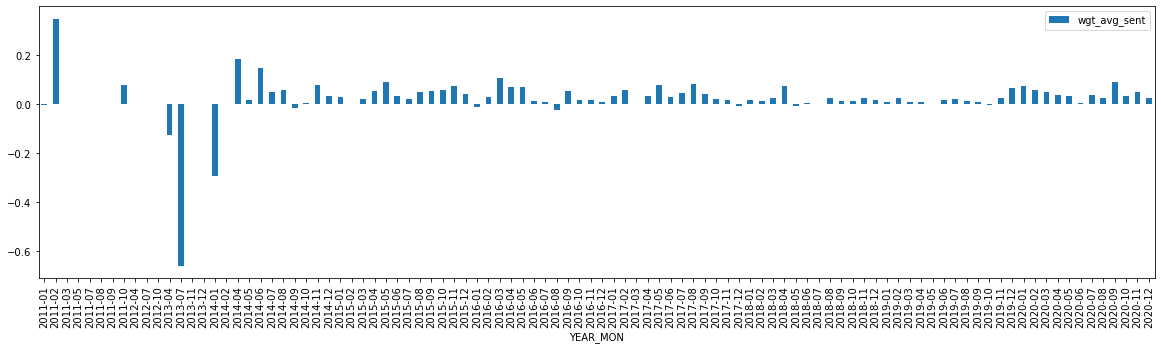

In [98]:

agg_posts[agg_posts['post_topic_nmf'] ==15].plot.bar(x='YEAR_MON', y='wgt_avg_sent', figsize=(20,5))


<AxesSubplot:xlabel='YEAR_MON'>

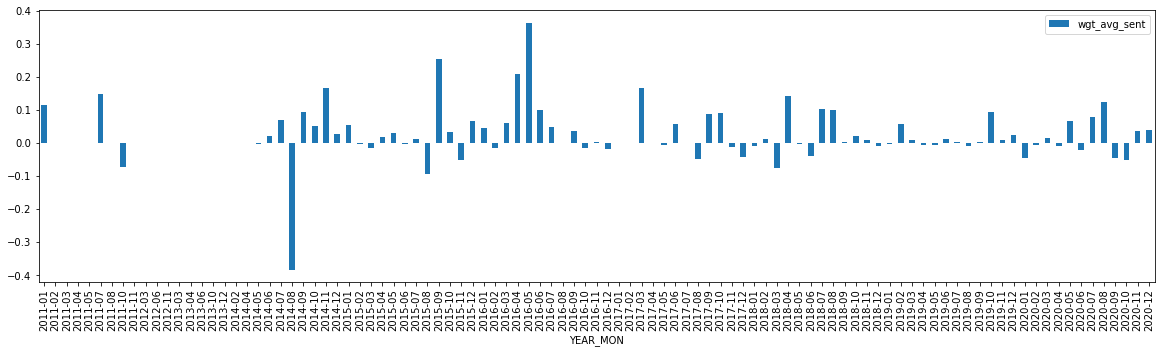

In [99]:
agg_posts[agg_posts['post_topic_nmf'] ==1].plot.bar(x='YEAR_MON', y='wgt_avg_sent', figsize=(20,5))

<AxesSubplot:xlabel='YEAR_MON'>

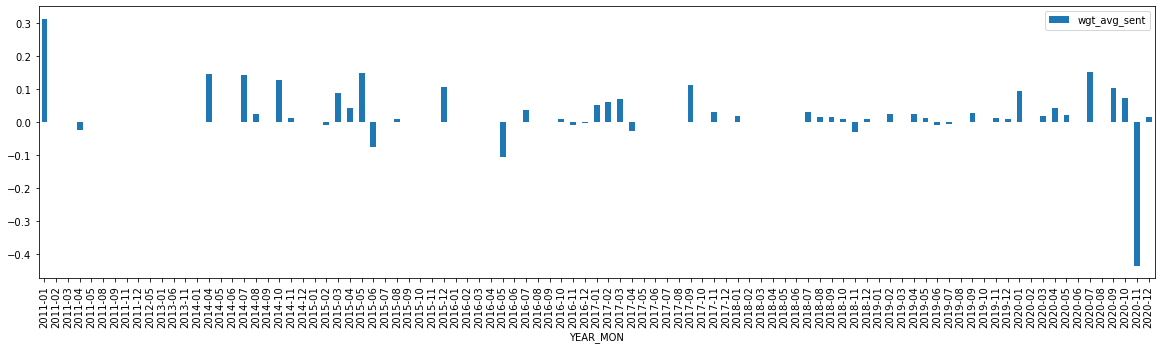

In [100]:
agg_posts[agg_posts['post_topic_nmf'] ==2].plot.bar(x='YEAR_MON', y='wgt_avg_sent', figsize=(20,5))

<AxesSubplot:xlabel='YEAR_MON'>

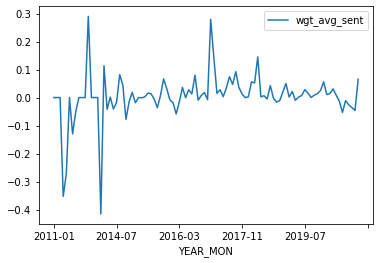

In [86]:
agg_posts[agg_posts['post_topic_nmf'] ==3].plot(x='YEAR_MON', y='wgt_avg_sent')

<AxesSubplot:xlabel='YEAR_MON'>

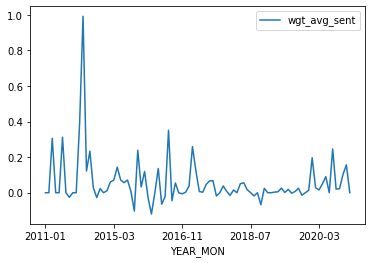

In [87]:
agg_posts[agg_posts['post_topic_nmf'] ==4].plot(x='YEAR_MON', y='wgt_avg_sent')

<AxesSubplot:xlabel='YEAR_MON'>

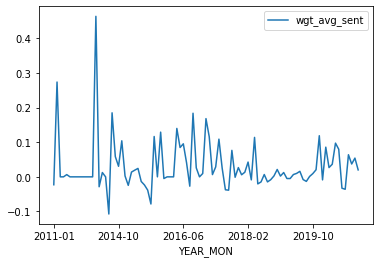

In [92]:
agg_posts[agg_posts['post_topic_nmf'] ==9].plot(x='YEAR_MON', y='wgt_avg_sent')

<AxesSubplot:xlabel='YEAR_MON'>

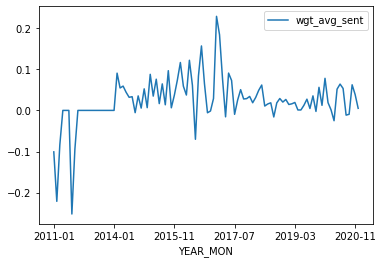

In [90]:
agg_posts[agg_posts['post_topic_nmf'] ==12].plot(x='YEAR_MON', y='wgt_avg_sent')

<AxesSubplot:xlabel='YEAR_MON'>

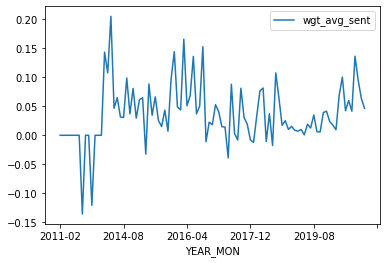

In [91]:
agg_posts[agg_posts['post_topic_nmf'] ==18].plot(x='YEAR_MON', y='wgt_avg_sent')

In [101]:
agg_posts.to_csv('posts_avg_sentiment.csv', index=False)